In [24]:
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import *
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier, XGBRegressor
import shap
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


ModuleNotFoundError: No module named 'xgboost'

In [6]:
print("AIRLINE DELAY ANALYSIS - COMPREHENSIVE ML PIPELINE")

df = pd.read_csv('/content/Airline_Delay_Cause.csv')
print(f"Dataset shape: {df.shape}")

# Handle missing values efficiently
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Fill numerical with median, drop categorical missing rows
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

df = df.dropna(subset=categorical_cols)



,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,12,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",72.0,5.0,2.46,1.00,...,0.0,0.81,0.0,0.0,672.0,61.0,574.0,20.0,0.0,17.0
1,2023,12,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",62.0,7.0,4.25,0.00,...,0.0,1.75,0.0,0.0,348.0,252.0,0.0,33.0,0.0,63.0
2,2023,12,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",95.0,10.0,5.94,0.00,...,0.0,3.00,0.0,0.0,859.0,536.0,0.0,47.0,0.0,276.0
3,2023,12,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",23.0,2.0,0.56,0.00,...,0.0,1.44,1.0,0.0,75.0,9.0,0.0,0.0,0.0,66.0
4,2023,12,9E,Endeavor Air Inc.,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",2111.0,256.0,76.88,8.75,...,0.0,117.94,1.0,0.0,21424.0,8906.0,732.0,1487.0,0.0,10299.0


In [7]:
print('Handle outliers using IQR')
outlier_cols = ['arr_flights', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']
for col in outlier_cols:
    if col in df.columns:
        Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        IQR = Q3 - Q1
        df[col] = df[col].clip(Q1 - 2*IQR, Q3 + 2*IQR)

print(f"Cleaned dataset shape: {df.shape}")

(179338, 21)

In [8]:
print("EXPLORATORY DATA ANALYSIS")

# Create target variables
df['is_delayed'] = (df['arr_delay'] > 15).astype(int)
df['delay_duration'] = df['arr_delay'].clip(lower=0)

# Advanced Feature Engineering
epsilon = 1
df['cancellation_rate'] = df['arr_cancelled'] / (df['arr_flights'] + epsilon)
df['diversion_rate'] = df['arr_diverted'] / (df['arr_flights'] + epsilon)

# Operational Adjustability Index (OAI)
controllable = df['carrier_ct'] + df['late_aircraft_ct']
uncontrollable = df['weather_ct'] + df['nas_ct'] + df['security_ct']
df['operational_adjustability_index'] = controllable / (controllable + uncontrollable + epsilon)

# Time-based features
df['quarter'] = ((df['month'] - 1) // 3) + 1
df['is_holiday_season'] = df['month'].isin([11, 12, 6, 7]).astype(int)
df['is_winter'] = df['month'].isin([12, 1, 2]).astype(int)

# Flight volume categories
df['flight_volume_category'] = pd.qcut(df['arr_flights'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

print("✓ Advanced features created including Operational Adjustability Index")

# ==================== COMPREHENSIVE CORRELATION & STATISTICAL ANALYSIS ====================
# Correlation heatmap for key variables
delay_factors = ['arr_flights', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct',
                'late_aircraft_ct', 'cancellation_rate', 'diversion_rate',
                'operational_adjustability_index', 'is_delayed']

correlation_matrix = df[delay_factors].corr()

# Statistical significance testing
significant_correlations = []
for i in range(len(delay_factors)):
    for j in range(i+1, len(delay_factors)):
        corr, p_value = pearsonr(df[delay_factors[i]], df[delay_factors[j]])
        if p_value < 0.05 and abs(corr) > 0.1:
            significant_correlations.append({
                'Feature1': delay_factors[i],
                'Feature2': delay_factors[j],
                'Correlation': corr,
                'P_Value': p_value,
                'Significance': 'High' if p_value < 0.001 else 'Medium'
            })

sig_corr_df = pd.DataFrame(significant_correlations).sort_values('Correlation', key=abs, ascending=False)
print(f"\nSignificant Correlations Found: {len(sig_corr_df)}")
print(sig_corr_df.head(10))

# ==================== TREND ANALYSIS ====================
# Monthly delay patterns with statistical testing
monthly_stats = df.groupby('month').agg({
    'is_delayed': ['mean', 'count'],
    'operational_adjustability_index': 'mean',
    'cancellation_rate': 'mean'
}).round(4)

# Seasonal analysis
seasonal_analysis = df.groupby('quarter').agg({
    'is_delayed': 'mean',
    'operational_adjustability_index': 'mean',
    'carrier_ct': 'mean',
    'weather_ct': 'mean'
}).round(4)

print(f"\nSeasonal Delay Patterns:")
print(seasonal_analysis)

# Carrier performance analysis (minimum threshold for reliability)
if 'carrier_name' in df.columns:
    carrier_analysis = df.groupby('carrier_name').agg({
        'is_delayed': ['mean', 'count'],
        'operational_adjustability_index': 'mean',
        'cancellation_rate': 'mean'
    })
    carrier_analysis = carrier_analysis[carrier_analysis[('is_delayed', 'count')] >= 100]
    carrier_analysis.columns = ['delay_rate', 'flight_count', 'oai_avg', 'cancel_rate']

    print(f"\nTop 5 Carriers by Delay Rate (min 100 flights):")
    print(carrier_analysis.nlargest(5, 'delay_rate')[['delay_rate', 'oai_avg', 'cancel_rate']].round(4))
    plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(3, 3, figsize=(20, 18))

# 1. Correlation heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, ax=axes[0,0])
axes[0,0].set_title('Correlation Matrix - Delay Factors')

# 2. OAI distribution by delay status
sns.boxplot(data=df, x='is_delayed', y='operational_adjustability_index', ax=axes[0,1])
axes[0,1].set_title('Operational Adjustability Index by Delay Status')
axes[0,1].set_xticklabels(['On-time', 'Delayed'])

# 3. Monthly trends
monthly_delay = df.groupby('month')['is_delayed'].mean()
axes[0,2].plot(monthly_delay.index, monthly_delay.values, marker='o', linewidth=2)
axes[0,2].set_title('Monthly Delay Rate Trends')
axes[0,2].set_xlabel('Month')
axes[0,2].set_ylabel('Delay Rate')
axes[0,2].grid(True, alpha=0.3)

# 4. Flight volume vs delay rate
volume_delay = df.groupby('flight_volume_category')['is_delayed'].mean()
axes[1,0].bar(range(len(volume_delay)), volume_delay.values, color='skyblue', alpha=0.8)
axes[1,0].set_title('Delay Rate by Flight Volume Category')
axes[1,0].set_xticks(range(len(volume_delay)))
axes[1,0].set_xticklabels(volume_delay.index, rotation=45)

# 5. Delay causes distribution
delay_causes = ['carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']
cause_totals = df[delay_causes].sum()
axes[1,1].pie(cause_totals.values, labels=cause_totals.index, autopct='%1.1f%%')
axes[1,1].set_title('Distribution of Delay Causes')

# 6. OAI vs Delay Duration scatter
delayed_flights = df[df['is_delayed'] == 1]
if len(delayed_flights) > 100:
    sample_size = min(1000, len(delayed_flights))
    sample_data = delayed_flights.sample(sample_size)
    axes[1,2].scatter(sample_data['operational_adjustability_index'],
                     sample_data['delay_duration'], alpha=0.6)
    axes[1,2].set_title('OAI vs Delay Duration')
    axes[1,2].set_xlabel('Operational Adjustability Index')
    axes[1,2].set_ylabel('Delay Duration (minutes)')

# 7. Quarterly performance
quarterly_stats = df.groupby('quarter').agg({'is_delayed': 'mean', 'operational_adjustability_index': 'mean'})
x = quarterly_stats.index
axes[2,0].bar(x - 0.2, quarterly_stats['is_delayed'], 0.4, label='Delay Rate', alpha=0.8)
ax2 = axes[2,0].twinx()
ax2.bar(x + 0.2, quarterly_stats['operational_adjustability_index'], 0.4,
        label='OAI', alpha=0.8, color='orange')
axes[2,0].set_title('Quarterly Performance: Delay Rate vs OAI')
axes[2,0].legend(loc='upper left')
ax2.legend(loc='upper right')

# 8. Cancellation vs Delay relationship
axes[2,1].scatter(df['cancellation_rate'], df['is_delayed'], alpha=0.6)
axes[2,1].set_title('Cancellation Rate vs Delay Probability')
axes[2,1].set_xlabel('Cancellation Rate')
axes[2,1].set_ylabel('Delay Status')

# 9. Top delay factors by importance (preliminary)
delay_corr = correlation_matrix['is_delayed'].abs().sort_values(ascending=True)
delay_corr = delay_corr[delay_corr.index != 'is_delayed'][-8:]
axes[2,2].barh(range(len(delay_corr)), delay_corr.values, color='green', alpha=0.7)
axes[2,2].set_yticks(range(len(delay_corr)))
axes[2,2].set_yticklabels(delay_corr.index)
axes[2,2].set_title('Top Delay Predictors (Correlation)')

plt.tight_layout()
plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179338 entries, 0 to 179337
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 179338 non-null  int64  
 1   month                179338 non-null  int64  
 2   carrier              179338 non-null  object 
 3   carrier_name         179338 non-null  object 
 4   airport              179338 non-null  object 
 5   airport_name         179338 non-null  object 
 6   arr_flights          178997 non-null  float64
 7   arr_del15            178747 non-null  float64
 8   carrier_ct           178997 non-null  float64
 9   weather_ct           178997 non-null  float64
 10  nas_ct               178997 non-null  float64
 11  security_ct          178997 non-null  float64
 12  late_aircraft_ct     178997 non-null  float64
 13  arr_cancelled        178997 non-null  float64
 14  arr_diverted         178997 non-null  float64
 15  arr_delay        

In [9]:
print("FEATURE PREPARATION AND EXTRACTION")

feature_columns = [
    'month', 'quarter', 'arr_flights', 'carrier_ct', 'weather_ct', 'nas_ct',
    'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
    'cancellation_rate', 'diversion_rate', 'operational_adjustability_index',
    'is_holiday_season', 'is_winter'
]

# Encode categorical variables if present
if 'carrier' in df.columns:
    carrier_counts = df['carrier'].value_counts()
    frequent_carriers = carrier_counts[carrier_counts >= 50].index
    df['carrier_encoded'] = df['carrier'].apply(
        lambda x: LabelEncoder().fit(frequent_carriers).transform([x])[0]
        if x in frequent_carriers else -1
    )
    feature_columns.append('carrier_encoded')

# Prepare final dataset
feature_columns = [col for col in feature_columns if col in df.columns]
X = df[feature_columns].copy()
y_classification = df['is_delayed']
y_regression = df['delay_duration']

# Remove any remaining missing values
mask = ~(X.isnull().any(axis=1) | y_classification.isnull())
X, y_classification, y_regression = X[mask], y_classification[mask], y_regression[mask]

print(f"Final modeling dataset: {X.shape}")
print(f"Features: {list(X.columns)}")

# ==================== TRAIN-TEST SPLIT ====================
X_train, X_test, y_train_clf, y_test_clf = train_test_split(
    X, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

# For regression (only delayed flights)
delayed_mask = y_regression > 0
X_reg = X[delayed_mask]
y_reg = y_regression[delayed_mask]

if len(X_reg) > 100:
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        X_reg, y_reg, test_size=0.2, random_state=42
    )

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


year                     0
month                    0
carrier                  0
carrier_name             0
airport                  0
airport_name             0
arr_flights            341
arr_del15              591
carrier_ct             341
weather_ct             341
nas_ct                 341
security_ct            341
late_aircraft_ct       341
arr_cancelled          341
arr_diverted           341
arr_delay              341
carrier_delay          341
weather_delay          341
nas_delay              341
security_delay         341
late_aircraft_delay    341
dtype: int64

In [ ]:
print("MODEL TRAINING & COMPREHENSIVE EVALUATION")

# Classification Models
models_clf = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=8,
                                          min_samples_split=20, class_weight='balanced',
                                          random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', max_depth=6,
                           scale_pos_weight=len(y_train_clf[y_train_clf==0])/len(y_train_clf[y_train_clf==1]))
}

# Regression Models (for delay duration)
models_reg = {
    'Linear Regression': LinearRegression(),
    'Random Forest Reg': RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42),
    'XGBoost Reg': XGBRegressor(random_state=42, max_depth=6)
}

# Train and evaluate classification models
clf_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models_clf.items():
    # Fit model
    if 'Logistic' in name:
        model.fit(X_train_scaled, y_train_clf)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        cv_scores = cross_val_score(model, X_train_scaled, y_train_clf, cv=cv, scoring='f1')
    else:
        model.fit(X_train, y_train_clf)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        cv_scores = cross_val_score(model, X_train, y_train_clf, cv=cv, scoring='f1')

    # Calculate comprehensive metrics
    clf_results[name] = {
        'Accuracy': accuracy_score(y_test_clf, y_pred),
        'Precision': precision_score(y_test_clf, y_pred),
        'Recall': recall_score(y_test_clf, y_pred),
        'F1_Score': f1_score(y_test_clf, y_pred),
        'AUC_ROC': roc_auc_score(y_test_clf, y_pred_proba),
        'CV_F1_Mean': cv_scores.mean(),
        'CV_F1_Std': cv_scores.std()
    }

# Train regression models if sufficient delayed flights
reg_results = {}
if len(X_reg) > 100:
    for name, model in models_reg.items():
        if 'Linear' in name:
            X_train_reg_scaled = scaler.fit_transform(X_train_reg)
            X_test_reg_scaled = scaler.transform(X_test_reg)
            model.fit(X_train_reg_scaled, y_train_reg)
            y_pred_reg = model.predict(X_test_reg_scaled)
        else:
            model.fit(X_train_reg, y_train_reg)
            y_pred_reg = model.predict(X_test_reg)

        reg_results[name] = {
            'MAE': mean_absolute_error(y_test_reg, y_pred_reg),
            'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)),
            'R2_Score': r2_score(y_test_reg, y_pred_reg)
        }

# Display results
print("CLASSIFICATION RESULTS:")
clf_df = pd.DataFrame(clf_results).T.round(4)
print(clf_df)

if reg_results:
    print("\nREGRESSION RESULTS:")
    reg_df = pd.DataFrame(reg_results).T.round(4)
    print(reg_df)



# Select best classification model
best_clf_model = models_clf['Random Forest']
best_clf_model.fit(X_train, y_train_clf)




In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Model Comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'AUC_ROC']
x = np.arange(len(clf_results))
width = 0.15

for i, metric in enumerate(metrics):
    values = [clf_results[model][metric] for model in clf_results.keys()]
    axes[0,0].bar(x + i*width, values, width, label=metric, alpha=0.8)

axes[0,0].set_xlabel('Models')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Classification Model Performance')
axes[0,0].set_xticks(x + width * 2)
axes[0,0].set_xticklabels(clf_results.keys(), rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Confusion Matrix (Best Model)
y_pred_best = best_clf_model.predict(X_test)
cm = confusion_matrix(y_test_clf, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title('Confusion Matrix - Random Forest')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# 3. ROC Curve
y_pred_proba_best = best_clf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test_clf, y_pred_proba_best)
auc_score = auc(fpr, tpr)
axes[0,2].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
axes[0,2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0,2].set_xlabel('False Positive Rate')
axes[0,2].set_ylabel('True Positive Rate')
axes[0,2].set_title('ROC Curve - Best Model')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)


# 5. Cross-validation scores
cv_means = [clf_results[model]['CV_F1_Mean'] for model in clf_results.keys()]
cv_stds = [clf_results[model]['CV_F1_Std'] for model in clf_results.keys()]
test_f1s = [clf_results[model]['F1_Score'] for model in clf_results.keys()]

x = range(len(clf_results))
axes[1,1].bar([i-0.2 for i in x], cv_means, 0.4, yerr=cv_stds,
              label='CV F1', alpha=0.8, capsize=5)
axes[1,1].bar([i+0.2 for i in x], test_f1s, 0.4,
              label='Test F1', alpha=0.8)
axes[1,1].set_xlabel('Models')
axes[1,1].set_ylabel('F1 Score')
axes[1,1].set_title('Cross-Validation vs Test Performance')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(clf_results.keys(), rotation=45)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. Regression Performance (if available)
if reg_results:
    reg_metrics = ['MAE', 'RMSE']
    reg_x = np.arange(len(reg_results))

    for i, metric in enumerate(reg_metrics):
        values = [reg_results[model][metric] for model in reg_results.keys()]
        axes[1,2].bar(reg_x + i*0.3, values, 0.3, label=metric, alpha=0.8)

    axes[1,2].set_xlabel('Models')
    axes[1,2].set_ylabel('Error')
    axes[1,2].set_title('Regression Model Performance')
    axes[1,2].set_xticks(reg_x + 0.15)
    axes[1,2].set_xticklabels(reg_results.keys(), rotation=45)
    axes[1,2].legend()
else:
    axes[1,2].text(0.5, 0.5, 'Insufficient delayed flights\nfor regression analysis',
                   ha='center', va='center', transform=axes[1,2].transAxes)
    axes[1,2].set_title('Regression Analysis - Insufficient Data')

plt.tight_layout()
plt.show()

,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,date
0,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",72.0,5.0,2.46,1.00,0.73,0.00,0.81,0.0,0.0,672.0,61.0,574.0,20.0,0.0,17.0,2023-12-01
1,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",62.0,7.0,4.25,0.00,1.00,0.00,1.75,0.0,0.0,348.0,252.0,0.0,33.0,0.0,63.0,2023-12-01
2,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",95.0,10.0,5.94,0.00,1.06,0.00,3.00,0.0,0.0,859.0,536.0,0.0,47.0,0.0,276.0,2023-12-01
3,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",23.0,2.0,0.56,0.00,0.00,0.00,1.44,1.0,0.0,75.0,9.0,0.0,0.0,0.0,66.0,2023-12-01
4,9E,Endeavor Air Inc.,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",2111.0,256.0,76.88,8.75,52.43,0.00,117.94,1.0,0.0,21424.0,8906.0,732.0,1487.0,0.0,10299.0,2023-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179333,WN,Southwest Airlines Co.,ONT,"Ontario, CA: Ontario International",892.0,184.0,59.21,2.61,22.41,0.98,98.79,3.0,2.0,8431.0,2661.0,123.0,1029.0,92.0,4526.0,2015-01-01
179334,WN,Southwest Airlines Co.,ORF,"Norfolk, VA: Norfolk International",151.0,45.0,18.00,2.01,7.19,0.00,17.80,0.0,0.0,2391.0,840.0,295.0,301.0,0.0,955.0,2015-01-01
179335,WN,Southwest Airlines Co.,PBI,"West Palm Beach/Palm Beach, FL: Palm Beach Int...",251.0,68.0,25.17,0.08,14.92,0.00,27.83,6.0,0.0,3405.0,1003.0,9.0,534.0,0.0,1859.0,2015-01-01
179336,WN,Southwest Airlines Co.,PDX,"Portland, OR: Portland International",793.0,173.0,64.00,1.27,21.12,0.00,86.60,0.0,1.0,7479.0,2370.0,143.0,689.0,0.0,4277.0,2015-01-01


In [13]:
print("COMPREHENSIVE ANALYSIS SUMMARY REPORT")

print(f"Dataset: {df.shape[0]:,} flights analyzed")
print(f"Delay Rate: {(df['is_delayed'].mean()*100):.2f}%")

#Operational Adjustability Index(OAI)
print(f"Average Operational Adjustability Index: {df['operational_adjustability_index'].mean():.4f}")

print(f"\nBest Classification Model: Random Forest")
print(f"  - Accuracy: {clf_results['Random Forest']['Accuracy']:.4f}")
print(f"  - F1-Score: {clf_results['Random Forest']['F1_Score']:.4f}")
print(f"  - AUC-ROC: {clf_results['Random Forest']['AUC_ROC']:.4f}")



print(f"  - Operational Adjustability Index shows {correlation_matrix.loc['operational_adjustability_index', 'is_delayed']:.3f} correlation with delays")
print(f"  - {len(sig_corr_df)} significant correlations identified")
print(f"  - Holiday seasons show {'higher' if df[df['is_holiday_season']==1]['is_delayed'].mean() > df[df['is_holiday_season']==0]['is_delayed'].mean() else 'lower'} delay rates")



<h1>This is the end</h1>

In [182]:
# Those flights which are exactly on time: 
# df[df['late_aircraft_delay'] == 0]

In [183]:
df = df.dropna(subset=['arr_delay','arr_del15'])

In [184]:
df.shape

(178747, 16)

In [185]:
df.isnull().sum()

arr_flights            0
arr_del15              0
carrier_ct             0
weather_ct             0
nas_ct                 0
security_ct            0
late_aircraft_ct       0
arr_cancelled          0
arr_diverted           0
arr_delay              0
carrier_delay          0
weather_delay          0
nas_delay              0
security_delay         0
late_aircraft_delay    0
date                   0
dtype: int64

In [186]:
from sklearn.model_selection import train_test_split

X = df.drop('late_aircraft_delay', axis=1)
y = df['late_aircraft_delay']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [187]:
y.shape

(178747,)

In [188]:
y.info()

<class 'pandas.core.series.Series'>
Index: 178747 entries, 0 to 179337
Series name: late_aircraft_delay
Non-Null Count   Dtype  
--------------   -----  
178747 non-null  float64
dtypes: float64(1)
memory usage: 2.7 MB


<h1>Encoding Categorical variables:(One-hot Encoding)</h1>

In [189]:
# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder(handle_unknown='ignore')
# X_train_new = ohe.fit_transform(X_train[['airport']]).toAarray()
# X_test_new = ohe.transform(X_test[['airport']]).toArray()

In [190]:
df.head()

,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,date
0,72.0,5.0,2.46,1.00,0.73,0.0,0.81,0.0,0.0,672.0,61.0,574.0,20.0,0.0,17.0,2023-12-01
1,62.0,7.0,4.25,0.00,1.00,0.0,1.75,0.0,0.0,348.0,252.0,0.0,33.0,0.0,63.0,2023-12-01
2,95.0,10.0,5.94,0.00,1.06,0.0,3.00,0.0,0.0,859.0,536.0,0.0,47.0,0.0,276.0,2023-12-01
3,23.0,2.0,0.56,0.00,0.00,0.0,1.44,1.0,0.0,75.0,9.0,0.0,0.0,0.0,66.0,2023-12-01
4,2111.0,256.0,76.88,8.75,52.43,0.0,117.94,1.0,0.0,21424.0,8906.0,732.0,1487.0,0.0,10299.0,2023-12-01


<h1>Exploratory data Analysis:</h1>

Text(0.5, 0, 'Minutes of Delay')

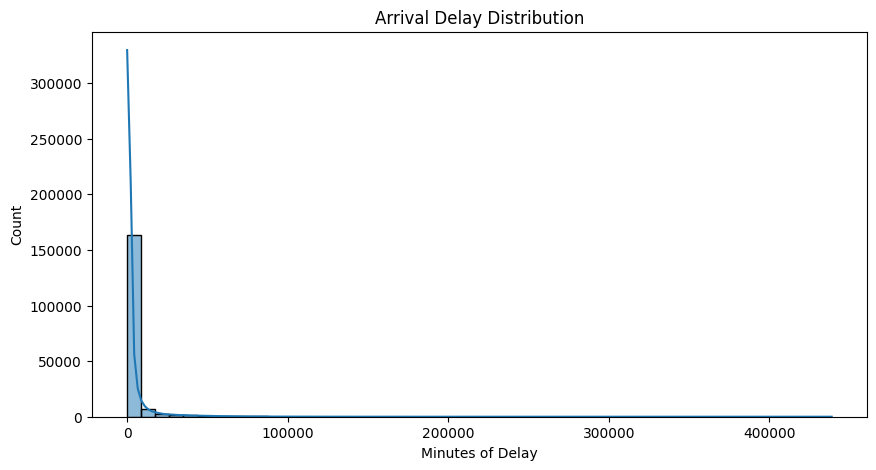

In [191]:
plt.figure(figsize=(10,5))
sns.histplot(df['arr_delay'], bins=50, kde=True)
plt.title("Arrival Delay Distribution")
plt.xlabel("Minutes of Delay")

In [192]:
# df['DepHour'] = pd.to_datetime(df['DepTime'], format='%H%M', errors='coerce').dt.hour
# sns.boxplot(x='DepHour', y='ArrDelay', data=df)
# plt.title("Delays by Departure Hour")

In [194]:
# df['airport'].value_counts()

In [196]:
# df['airport'].unique()

<h1>Model Decleration and prediction:</h1>

In [200]:
df = df.drop(['date'],axis=1)
df

,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,72.0,5.0,2.46,1.00,0.73,0.00,0.81,0.0,0.0,672.0,61.0,574.0,20.0,0.0,17.0
1,62.0,7.0,4.25,0.00,1.00,0.00,1.75,0.0,0.0,348.0,252.0,0.0,33.0,0.0,63.0
2,95.0,10.0,5.94,0.00,1.06,0.00,3.00,0.0,0.0,859.0,536.0,0.0,47.0,0.0,276.0
3,23.0,2.0,0.56,0.00,0.00,0.00,1.44,1.0,0.0,75.0,9.0,0.0,0.0,0.0,66.0
4,2111.0,256.0,76.88,8.75,52.43,0.00,117.94,1.0,0.0,21424.0,8906.0,732.0,1487.0,0.0,10299.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179333,892.0,184.0,59.21,2.61,22.41,0.98,98.79,3.0,2.0,8431.0,2661.0,123.0,1029.0,92.0,4526.0
179334,151.0,45.0,18.00,2.01,7.19,0.00,17.80,0.0,0.0,2391.0,840.0,295.0,301.0,0.0,955.0
179335,251.0,68.0,25.17,0.08,14.92,0.00,27.83,6.0,0.0,3405.0,1003.0,9.0,534.0,0.0,1859.0
179336,793.0,173.0,64.00,1.27,21.12,0.00,86.60,0.0,1.0,7479.0,2370.0,143.0,689.0,0.0,4277.0
